<center><h1>ECSE 415 Course Project - Counting People in a
Shopping Mall</h1>
<h4>SVM with LBP Features (Part 2)</h4></center>

<h3>Team Members:</h3>
<center>
Lawrence Zhang, 260664442<br>
Yinuo Wang, 260766084<br>
Fei Peng, 260712440<br>
Yukai Zhang, 260710915<br>
</center>

# Install detectron2

In [9]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/ECSE_415_Project/frames/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1oHyE7rxbw-bo9WbZ2w2kPnRlpwBVEAKl/ECSE_415_Project/frames


In [2]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [5]:
import os
import random

In [ ]:
path = "./"
files = sorted(os.listdir(path))
count_people = []
positive_patches = []
for file in iter(files):
    im = cv2.imread(path + file)
    # im = cv2.imread("./seq_002000.jpg")
    cfg = get_cfg()
    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    outputs = predictor(im)
    boxes = outputs["instances"].pred_boxes[outputs["instances"].pred_classes == 0]
    count_people.append(len(boxes))
    positive_patches.append(boxes)
    print("Frame: {}, number of people: {}".format(file, len(boxes)))

/usr/local/lib/python3.6/dist-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


Frame: seq_000001.jpg, number of people: 25
Frame: seq_000002.jpg, number of people: 32
Frame: seq_000003.jpg, number of people: 32
Frame: seq_000004.jpg, number of people: 34
Frame: seq_000005.jpg, number of people: 33
Frame: seq_000006.jpg, number of people: 25
Frame: seq_000007.jpg, number of people: 30
Frame: seq_000008.jpg, number of people: 31
Frame: seq_000009.jpg, number of people: 17
Frame: seq_000010.jpg, number of people: 22
Frame: seq_000011.jpg, number of people: 14
Frame: seq_000012.jpg, number of people: 15
Frame: seq_000013.jpg, number of people: 18
Frame: seq_000014.jpg, number of people: 18
Frame: seq_000015.jpg, number of people: 11
Frame: seq_000016.jpg, number of people: 15
Frame: seq_000017.jpg, number of people: 11
Frame: seq_000018.jpg, number of people: 21
Frame: seq_000019.jpg, number of people: 25
Frame: seq_000020.jpg, number of people: 25
Frame: seq_000021.jpg, number of people: 25
Frame: seq_000022.jpg, number of people: 18
Frame: seq_000023.jpg, number of

## Generate Positive Data

In [ ]:
numpy_patches = []
for i, patches in enumerate(positive_patches):
    numpy_patches.append(patches.tensor.cpu().numpy().squeeze())

## Generate Negative Data

In [ ]:
x_coor_list = np.linspace(0, 640, num=80, endpoint=False) # horizontal
y_coor_list = np.linspace(0, 480, num=20, endpoint=False) # vertical

coor_samples = []

# for people_box in random.sample(numpy_patches, 200):
for people_box in numpy_patches:

    coor_list = []

    for i, y in enumerate(y_coor_list):
        for j, x in enumerate(x_coor_list):
            x_check = len(people_box[people_box[:,2]<x])+len(people_box[people_box[:,0]>(x+48)])
            y_check = len(people_box[people_box[:,3]<y])+len(people_box[people_box[:,1]>(y+144)])
            if(x_check == people_box.shape[0] or y_check == people_box.shape[0]):
                coor_list.append([x,y,(x+48),(y+144)])

    for i, y in enumerate(y_coor_list):
        for j, x in enumerate(x_coor_list):
            x_check = len(people_box[people_box[:,2]<x])+len(people_box[people_box[:,0]>(x+32)])
            y_check = len(people_box[people_box[:,3]<y])+len(people_box[people_box[:,1]>(y+96)])
            if(x_check == people_box.shape[0] or y_check == people_box.shape[0]):
                coor_list.append([x,y,(x+32),(y+96)])

    for i, y in enumerate(y_coor_list):
        for j, x in enumerate(x_coor_list):
            x_check = len(people_box[people_box[:,2]<x])+len(people_box[people_box[:,0]>(x+24)])
            y_check = len(people_box[people_box[:,3]<y])+len(people_box[people_box[:,1]>(y+72)])
            if(x_check == people_box.shape[0] or y_check == people_box.shape[0]):
                coor_list.append([x,y,(x+32),(y+96)])

    for i, y in enumerate(y_coor_list):
        for j, x in enumerate(x_coor_list):
            x_check = len(people_box[people_box[:,2]<x])+len(people_box[people_box[:,0]>(x+16)])
            y_check = len(people_box[people_box[:,3]<y])+len(people_box[people_box[:,1]>(y+48)])
            if(x_check == people_box.shape[0] or y_check == people_box.shape[0]):
                coor_list.append([x,y,(x+16),(y+48)])

    coor_samples.append(random.sample(coor_list, min(len(people_box),len(coor_list))))

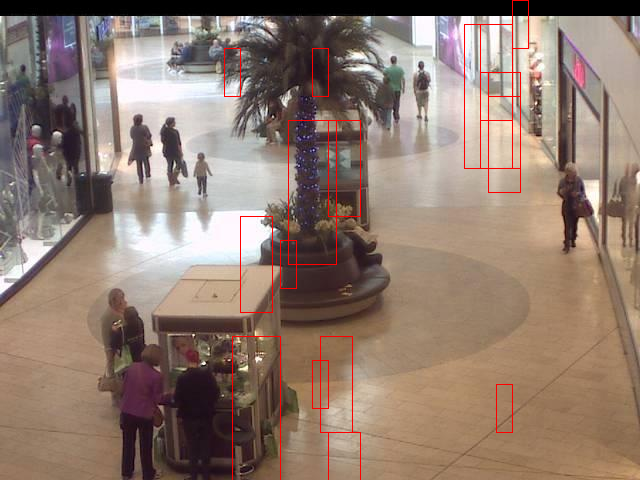

In [ ]:
image = cv2.imread(path + files[526])
output = image.copy()
for coor_sample in iter(coor_samples[526]):
    output = cv2.rectangle(output,(int(coor_sample[0]), int(coor_sample[1])),(int(coor_sample[2]), int(coor_sample[3])),(0,0,255),1)
cv2_imshow(output)

## Dump Data

In [ ]:
from numpy import asarray
from numpy import save
save('../Data/numpy_patches.npy', np.asarray(numpy_patches))
save('../Data/count_people.npy', np.asarray(count_people))
save('../Data/coor_samples.npy', np.asarray(coor_samples))

## Load Data

In [10]:
from numpy import load
numpy_patches = load('../Data/numpy_patches.npy', allow_pickle=True)
count_people = load('../Data/count_people.npy', allow_pickle=True)
coor_samples = load('../Data/coor_samples.npy', allow_pickle=True)

In [63]:
path = "./"
files = sorted(os.listdir(path))

# LBP Feature

In [12]:
from skimage.feature import local_binary_pattern

In [13]:
def compute_lbp(images):
    features = []
    img_size = (72, 24) # h x w in pixels
    # img_size = (24, 8) # h x w in pixels
    radius = 1
    n_points = 8 * radius

    for image in images:
        # resize the images
        resized = cv2.resize(image, img_size, interpolation=cv2.INTER_AREA)
        features.append(local_binary_pattern(resized, n_points, radius).reshape(1, -1))
    
    features = np.vstack(features)
    return features

In [14]:
import matplotlib.pyplot as plt

In [15]:
num_img = np.arange(0,2000)
path = "./"
files = sorted(os.listdir(path))
sub_list = []
for i in random.sample(list(num_img), 200):
    im = cv2.imread(path + files[i], cv2.IMREAD_GRAYSCALE)
    for coor in numpy_patches[i]:
        coor = coor.astype(int)
        sub_list.append(im[coor[1]:coor[3],coor[0]:coor[2]])

pos_lbp = compute_lbp(sub_list)

In [16]:
print(len(pos_lbp))
print(pos_lbp[0].shape)

4592
(1728,)


In [17]:
num_img = np.arange(0,2000)
path = "./"
files = sorted(os.listdir(path))
sub_list = []
for i in random.sample(list(num_img), 200):
    im = cv2.imread(path + files[i], cv2.IMREAD_GRAYSCALE)
    for coor in coor_samples[i]:
        coor = np.asarray(coor, dtype=int)
        sub_list.append(im[coor[1]:coor[3],coor[0]:coor[2]])

neg_lbp = compute_lbp(sub_list)

In [18]:
print(len(neg_lbp))
print(neg_lbp[0].shape)

4739
(1728,)


# Train SVC

In [19]:
from sklearn import svm

In [20]:
clf = svm.SVC(gamma='auto', kernel='linear')
train_X = np.concatenate((np.asarray(pos_lbp), np.asarray(neg_lbp)))
train_y = np.concatenate((np.ones(len(pos_lbp)),np.zeros(len(neg_lbp))))
# clf.fit(train_X, train_y)

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.2, random_state=0)
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## Dump clf (SVM)

In [ ]:
from sklearn.externals import joblib
joblib.dump(clf, '../Data/svc.npy')

['../Data/svc.npy']

## Load clf (SVM)

In [ ]:
clf_load = joblib.load('../Data/svc.npy')

# Pyramid Sliding Window

In [22]:
from sklearn.metrics import accuracy_score
print(X_test.shape)
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

(1867, 1728)


0.8264595607927155

In [23]:
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0], step_size):
        for x in range(0, image.shape[1], step_size):
            yield (x, y, image[y: y + window_size[0], x: x + window_size[1]])

In [24]:
def pyramid(image, scale=1.5, min_size=(145, 200)):
    yield image
    while True:
        h = int(image.shape[0] / scale)
        w = int(image.shape[1] / scale)
        image = cv2.resize(image, (h, w), interpolation=cv2.INTER_AREA)
        if image.shape[0] < min_size[0] or image.shape[1] < min_size[1]:
            break
        yield image

# Non-Maximum Suppression and People Counting

In [25]:
from time import time
from imutils.object_detection import non_max_suppression
from sklearn.metrics import mean_squared_error

In [42]:
def svm_count(img_no, det_thresh):
    tic = time()
    image = cv2.imread(path + files[img_no], cv2.IMREAD_GRAYSCALE)
    win_w = 16
    win_h = 48
    pred = 0
    svm_boxes = []
    sc = []
    frac = 1
    for resized in pyramid(image, scale=1.5):

        for (x, y, window) in sliding_window(resized, step_size=16, window_size=(win_h, win_w)):
            if window.shape[0] != win_h or window.shape[1] != win_w:
                continue
            clone = window.copy()
            clone = (clone,)
            lbp_clone = compute_lbp(clone)
            pred = clf.predict(lbp_clone)
            if pred:
                if clf.decision_function(lbp_clone) > det_thresh:
                    sc.append(clf.decision_function(lbp_clone))
                    svm_boxes.append([int(x*frac), int(y*frac), int((x+win_w)*frac), int((y+win_h)*frac)])
        frac *= 1.5

    # people counting with non-maximum suppression
    pick = non_max_suppression(np.asarray(svm_boxes), probs=np.asarray(sc).squeeze(), overlapThresh=0.1)
    # return len(pick)
    return pick

# Example of Result (LBP Feature)

In [33]:
svm_people_count = svm_count(1999, 3)

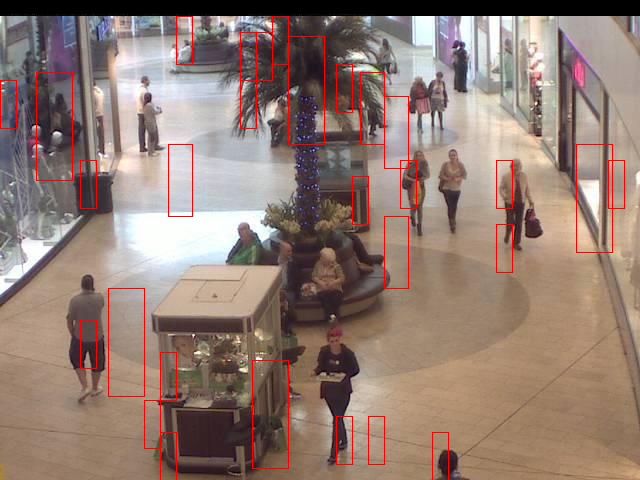

In [34]:
image = cv2.imread(path + files[1999])
output = image.copy()
for svm_box in iter(svm_people_count):
    output = cv2.rectangle(output,(int(svm_box[0]), int(svm_box[1])),(int(svm_box[2]), int(svm_box[3])),(0,0,255),1)
cv2_imshow(output)

# IoU Calculation

In [55]:
det_threshold = 3.3

In [56]:
IoU = []
import random
list_of_numbers = []
haar_count = []

# randomly pick 100 number within 0 and 1999
for x in range (0,100):
    list_of_numbers.append(random.randint(0,1999))

#for i in range(2000):
for i in list_of_numbers:
    svm_image_mask = np.zeros((640,480), dtype=int)
    fb_image_mask = np.zeros((640,480), dtype=int)
    svm_count_peoples = svm_count(i, det_threshold)
    haar_count.append(len(svm_count_peoples))
    for svm_count_people in svm_count_peoples:
        svm_image_mask[svm_count_people[0]:svm_count_people[2], svm_count_people[1]:svm_count_people[3]] = 1
    for fb_count_people in numpy_patches[i]:
        fb_count_people = fb_count_people.astype(int)
        fb_image_mask[fb_count_people[0]:fb_count_people[2], fb_count_people[1]:fb_count_people[3]] = 1
    sum_image_mask = (fb_image_mask + svm_image_mask).reshape(-1)
    IoU.append(np.sum(sum_image_mask == 2) / np.sum(sum_image_mask > 0))
    print("Image: {}, IoU: {}, number of people: {}".format(i+1, IoU[-1], haar_count[-1]))
    
print(np.mean(IoU))

Image: 787, IoU: 0.10871018677895217, number of people: 29
Image: 708, IoU: 0.11532827524038461, number of people: 27
Image: 647, IoU: 0.17167207259261205, number of people: 39
Image: 421, IoU: 0.15776488139149822, number of people: 43
Image: 1137, IoU: 0.15348581733011368, number of people: 27
Image: 1204, IoU: 0.10469484345005627, number of people: 40
Image: 832, IoU: 0.17784263895528774, number of people: 28
Image: 957, IoU: 0.10022518660768377, number of people: 29
Image: 1076, IoU: 0.08603807796917498, number of people: 30
Image: 1654, IoU: 0.11183237871444657, number of people: 25
Image: 931, IoU: 0.09508196721311475, number of people: 32
Image: 1731, IoU: 0.12888156526469036, number of people: 33
Image: 264, IoU: 0.08517876200640341, number of people: 28
Image: 761, IoU: 0.15067846607669616, number of people: 36
Image: 776, IoU: 0.11213882602612378, number of people: 31
Image: 1193, IoU: 0.15354719998624283, number of people: 37
Image: 211, IoU: 0.07607044719359066, number of pe

In [57]:
print("Average IoU for 100 random samples is {}".format(np.mean(IoU)))
print("best IoU is {} at image {}   ".format(np.max(IoU), list_of_numbers[np.argmax(IoU)] + 1))

Average IoU for 100 random samples is 0.12668945670096096
best IoU is 0.22434074935263965 at image 177   


In [58]:
print(np.mean(haar_count))

31.86


In [59]:
IoU = []
LBP_count = []
for i in range(2000):
    svm_image_mask = np.zeros((640,480), dtype=int)
    fb_image_mask = np.zeros((640,480), dtype=int)
    svm_count_peoples = svm_count(i, 3.3)
    LBP_count.append(len(svm_count_peoples))
    for svm_count_people in svm_count_peoples:
        svm_image_mask[svm_count_people[0]:svm_count_people[2], svm_count_people[1]:svm_count_people[3]] = 1
    for fb_count_people in numpy_patches[i]:
        fb_count_people = fb_count_people.astype(int)
        fb_image_mask[fb_count_people[0]:fb_count_people[2], fb_count_people[1]:fb_count_people[3]] = 1
    sum_image_mask = (fb_image_mask + svm_image_mask).reshape(-1)
    IoU.append(np.sum(sum_image_mask == 2) / np.sum(sum_image_mask > 0))
    print("Image: {}, IoU: {}, number of people: {}".format(i+1, IoU[-1], LBP_count[-1]))
print(np.mean(IoU))

Image: 1, IoU: 0.13267299616578418, number of people: 41
Image: 2, IoU: 0.14241356843262615, number of people: 33
Image: 3, IoU: 0.12875526520381997, number of people: 29
Image: 4, IoU: 0.13947084008812405, number of people: 31
Image: 5, IoU: 0.13908174285532776, number of people: 37
Image: 6, IoU: 0.10260738399655223, number of people: 41
Image: 7, IoU: 0.14334976957040188, number of people: 33
Image: 8, IoU: 0.15095120912403578, number of people: 32
Image: 9, IoU: 0.11458619364050744, number of people: 26
Image: 10, IoU: 0.09943804504966655, number of people: 25
Image: 11, IoU: 0.15116808848250618, number of people: 30
Image: 12, IoU: 0.05186708518237904, number of people: 30
Image: 13, IoU: 0.14522345745866913, number of people: 27
Image: 14, IoU: 0.15547239606856356, number of people: 33
Image: 15, IoU: 0.03981801018276358, number of people: 38
Image: 16, IoU: 0.060042750792363826, number of people: 27
Image: 17, IoU: 0.011158505927956273, number of people: 23
Image: 18, IoU: 0.117

In [61]:
print("Average IoU for 100 random samples is {}".format(np.mean(IoU)))
print("best IoU is {} at image {}   ".format(np.max(IoU), np.argmax(IoU)))

Average IoU for 100 random samples is 0.12150365794383582
best IoU is 0.2794397510899882 at image 418   


In [64]:
svm_people_count = svm_count(417, 3.3)

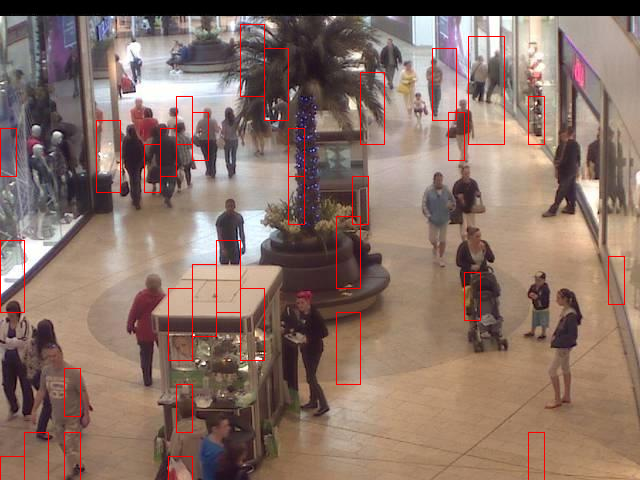

In [65]:
image = cv2.imread(path + files[417])
output = image.copy()
for svm_box in iter(svm_people_count):
    output = cv2.rectangle(output,(int(svm_box[0]), int(svm_box[1])),(int(svm_box[2]), int(svm_box[3])),(0,0,255),1)
cv2_imshow(output)

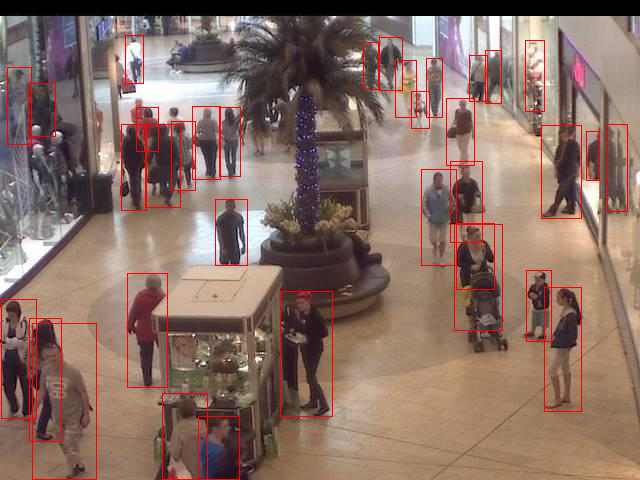

In [66]:
# show ground truth

image = cv2.imread(path + files[417])
output = image.copy()
for svm_box in numpy_patches[417]:
    output = cv2.rectangle(output,(int(svm_box[0]), int(svm_box[1])),(int(svm_box[2]), int(svm_box[3])),(0,0,255),1)
cv2_imshow(output)

In [60]:
import pandas as pd
result = {'id': np.arange(1,2001), 'count': LBP_count}
df = pd.DataFrame(data=result)
df.to_csv('../result_LBP.csv', index=False)
from google.colab import files
files.download('../result_LBP.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>